# 1. Basics in Numerical Methods

In [1]:
# Import necessary packages for all the tasks
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_laguerre
from scipy.stats import norm, qmc
from sklearn.linear_model import LinearRegression

### 1.1 Gauss-Hermite Quadrature Pricing

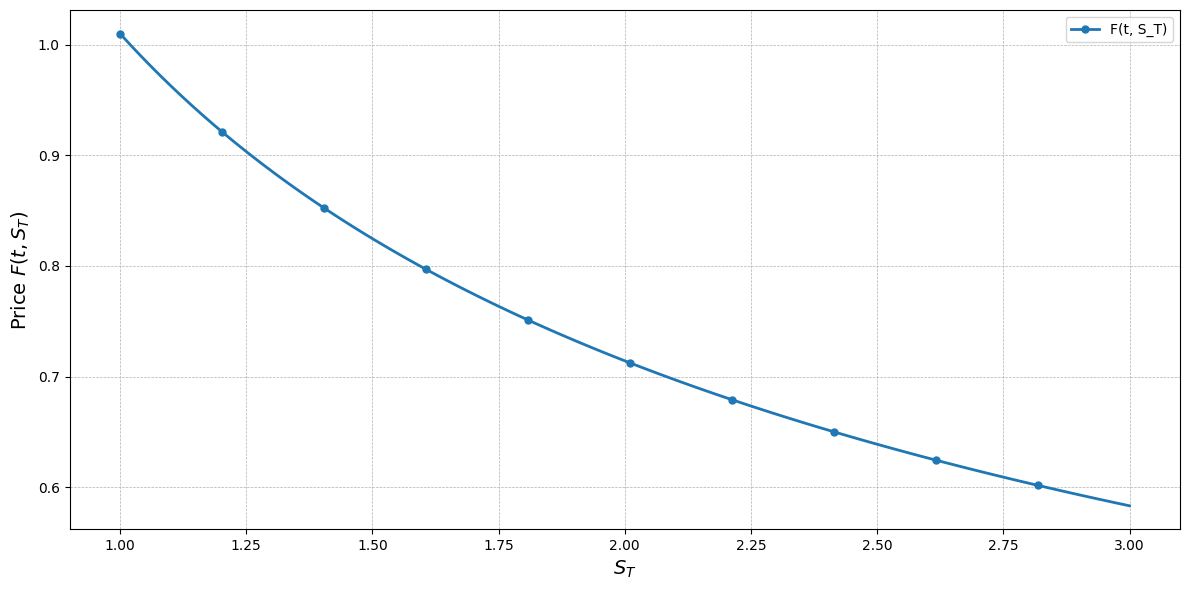

In [2]:
# Creating our own Guass-Hermite Quadrature Function
def ghq_price(S_lower, S_upper, r, TTM, N, sigma):
    """
    This function returns:
    - ST_values (np.ndarray): Array of Stock price values
    - price_values (np.ndarray): Array of derivative prices
    """
    # Retreiving our nodes and weights 
    nodes, weights = np.polynomial.hermite.hermgauss(N)

    # Creating 100 equal spaced values between S_lower and S_Upper
    ST_values = np.linspace(S_lower, S_upper, 100)

    # Initializing an empty list
    price_values = np.zeros_like(ST_values)
    
   # Loop over each S_T to compute F(t, S_T)
    for k, S_T in enumerate(ST_values):
        price = 0.0
        for i in range(N):
            x = nodes[i] 
            # Define the integrand function for GHQ
            integrand = np.exp((- r + 0.5 * sigma**2) * TTM + np.sqrt(2 * TTM) * -sigma * x) / np.sqrt(S_T * np.pi)
            # Accumulate the weighted integrand
            price += weights[i] * integrand
        
        # Assign the computed price to the corresponding S_T
        price_values[k] = price
    
    # Returning our main values after processing all S_T
    return ST_values, price_values


# =========================================================
# Plotting function
# =========================================================
def plot_prices(ST_values, price_values):
    
   # Initializing figure size
    plt.figure(figsize=(12, 6))

    # Plotting
    plt.plot(ST_values, price_values, label="F(t, S_T)", linewidth=2, marker="o", markersize=5, markevery=10)
    
    # Labels and title with increased font size
    plt.xlabel("$S_T$", fontsize=14) 
    plt.ylabel("Price $F(t,S_T)$", fontsize=14)
    
    # Increase tick size
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Other configurations
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(fontsize=10)
    plt.tight_layout()  # Adjusts plot parameters for a tight layout
    
    plt.show()

# =========================================================
# Parameters and functions for the main function
# =========================================================
def main():
    r = 0.02
    sigma = 0.2
    TTM = 0.5
    S_lower = 1
    S_upper = 3
    N = 100
    
    # Computing the price
    ST_values, price_values = ghq_price(S_lower, S_upper, r, TTM, N, sigma)

    # Plot the result
    plot_prices(ST_values, price_values)

# Initializing our main function
if __name__ == "__main__":
    main()

### 1.2 Discounted Utility

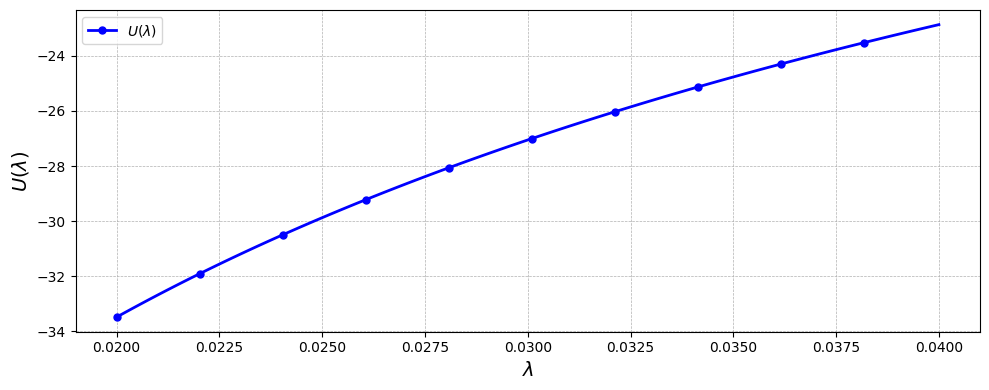

In [3]:
# Creating our own Gauss-Laguerre Quadrature Function
def glq_function(lambda_lower, lambda_upper, rho, N_nodes, num_lambda):
    """
    This function returns:
    - lambda_values (np.ndarray): Array of lambda values
    - U_values (np.ndarray): Array of discounted utility values
    """
    
    # Retrieve Guauss-Laguerre nodes and weights
    nodes, weights = roots_laguerre(N_nodes)

    # Generate uniformly spaced lambda values
    lambda_values = np.linspace(lambda_lower, lambda_upper, num_lambda)

    # Initialize empty array to store U_values
    U_values = np.zeros_like(lambda_values)

    # Iterate over each lambda to compute U(lambda)
    for k, lambda_i in enumerate(lambda_values):
        a = lambda_i / rho      # Transformation parameter

        # Compute the integrand at each node
        integrand = np.log(1 - np.exp(-a * nodes))

        # Approximate the integral using G-L Quadrature
        U_i = (1 / rho) * np.sum(weights * integrand)

        # Adding the computed utility to the array
        U_values[k] = U_i
    
    return lambda_values, U_values


# =========================================================
# Plotting function
# =========================================================
def plot_utilities(lambda_values, U_values):
    # Initializing figure size
    plt.figure(figsize=(10, 4))

    # Plot
    plt.plot(lambda_values, U_values, label="$U(\\lambda)$", linewidth=2, marker="o", markersize=5, markevery=10, color = "blue")

    # Other configurations
    plt.xlabel('$\\lambda$', fontsize=14) 
    plt.ylabel('$U(\\lambda)$', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(fontsize=10)
    plt.tight_layout()  # Adjusts plot parameters for a tight layout
    
    plt.show()

# =========================================================
# Parameters and functions for the main function
# =========================================================
def main():
    rho = 0.05
    lambda_lower = 0.02
    lambda_upper = 0.04
    N_nodes = 100
    num_lambda = 100

    # Computing the discounted utility
    lambda_values, U_values = glq_function(lambda_lower, lambda_upper, rho, N_nodes, num_lambda)
    
    # Plot the result
    plot_utilities(lambda_values, U_values)

# Initializing our main function
if __name__ == "__main__":
    main()

### 1.3 Projection Method

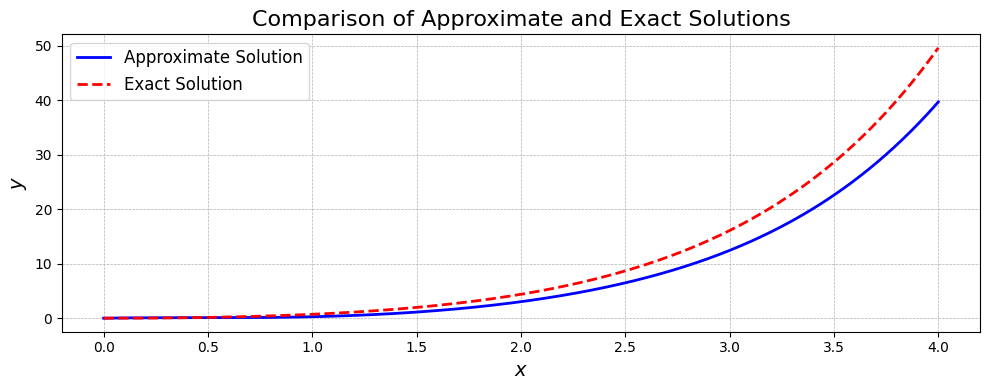

In [4]:
# =========================================================
# We can solve this analytically
# =========================================================
def y_exact(x):
    """
    This function returns:
     - y (np.ndarray): Exact solution y(x)
    """
    return np.exp(x) - x - 1


# =========================================================
# Chebyshev Nodes
# =========================================================
def chebyshev_nodes(a, b, N):
    """
    This function generate Chebyshev Nodes in the interval [a, b] and the function returns:
    - nodes (np.ndarray): Array of Chebyshev Nodes
    """
    k = np.arange(N + 1)
    nodes =  0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * k - 1) * np.pi / (2 * N))
    return nodes 


# =========================================================
# Collocation with Chebyshev nodes
# =========================================================
def collocation_method_chebyshev(a, b, N):
    """
    This function returns:
    - c (np.ndarray): Coefficients for the approximate solution
    """
    # Get the nodes
    x_nodes = chebyshev_nodes(a, b, N + 1)

    # Number of unkown coefficients (c_0 to c_n)
    num_coeffs = N + 1
    
    # Initialize matrix A and vector B
    A = np.zeros((N + 1, num_coeffs))
    b_vec = np.zeros(N + 1)

    # c0 = 0 from the initial condition
    c0 = 0

    # Construct the system
    for i in range(N + 1):
        x_i = x_nodes[i]
        b_vec[i] = x_i  # Right-hand side is x_i

        for k in range(1, N + 1):
            # Compute A[i, k-1] since k starts from 1
            A[i, k - 1] = k * x_i ** (k - 1) - x_i ** k

    # Solve the linear system A c = b - c0_term
    b_vec[-1] = 0
    c = np.linalg.lstsq(A, b_vec, rcond=None)[0]

    # Add c0 = 0 at the beginning of c
    c_full = np.hstack(([c0], c))

    return c_full


# =========================================================
# Approximation
# =========================================================
def y_approximate(x, c):
    """
    This function returns:
    - y (np.ndarray): Approximate solution y(x)
    """
    y = np.zeros_like(x)
    for k in range(len(c)):
        y += c[k] * x **k
    return y


# =========================================================
# Plotting the solution
# =========================================================
def plot_solution(x, y_approx, y_exact):
    # Initializing figure size
    plt.figure(figsize=(10, 4))

    # Plot approximate solution
    plt.plot(x, y_approx, label="Approximate Solution", linewidth=2, color="blue")

    # Plot exact solution
    plt.plot(x, y_exact, label="Exact Solution", linewidth=2, linestyle='--', color="red")

    # Plot settings
    plt.xlabel('$x$', fontsize=14)
    plt.ylabel('$y$', fontsize=14)
    plt.title('Comparison of Approximate and Exact Solutions', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# =========================================================
# Parameters and functions for the main function
# =========================================================
def main():
    # Parameters
    a = 0
    b = 4
    N = 5

    # Solve using collocation method with Chebyshev nodes
    c = collocation_method_chebyshev(a, b, N)

    # Generate values for x 
    x = np.linspace(a, b, 400)

    # Compute approximate solution
    y_approx = y_approximate(x, c)

    # Compute approximate solution
    y_ex = y_exact(x)

    # Plot the solution
    plot_solution(x, y_approx, y_ex)
    

# Initializing our main function
if __name__ == "__main__":
    main()

### 1.4 Life-Cycle Consumption Problem


#### A: TPBVP using Shooting Method

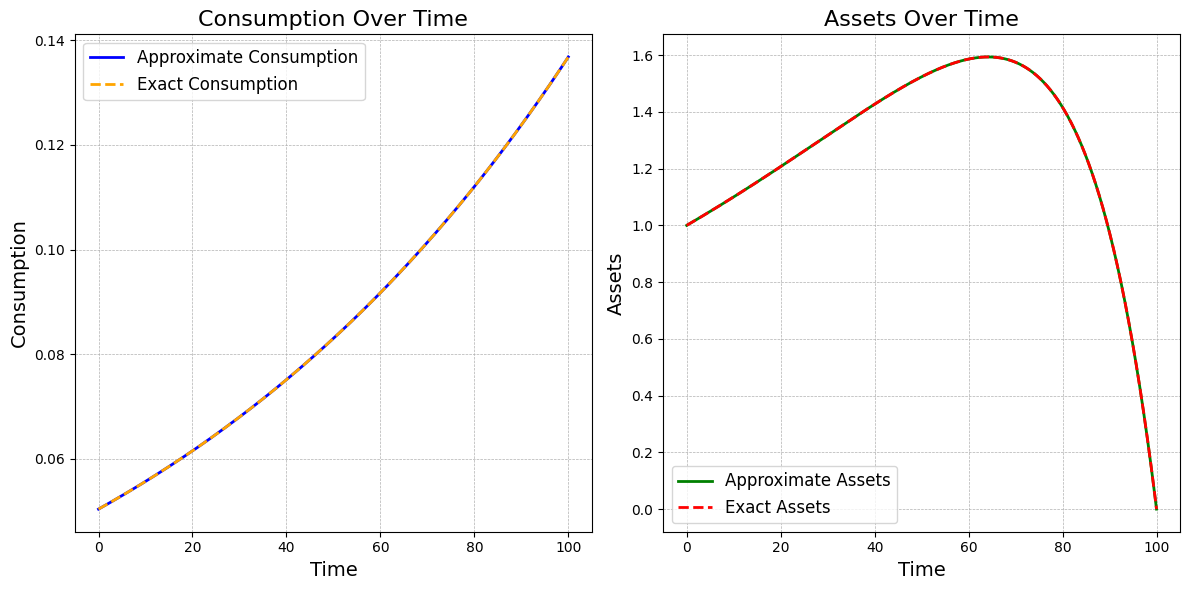

In [5]:
# We can compute the solution for this analytically and compare this with the numerically solution
def compute_exact_solution(rho, r_interest, asset_initial, asset_terminal, time_vector):
    """
    This function returns:
    - asset_values (np.ndarray): Exact asset values over time
    - consumption_values (np.ndarray): Exact consumption values over time
    """
    # Initial consumption calculation based on boundary conditions
    c_initial = (rho * (asset_terminal * np.exp(-r_interest * time_vector[-1]) - asset_initial)) / (np.exp(-rho * time_vector[-1]) - 1)
    
    # Creating empty np.ndarray's for both asset and consumption
    asset_values = np.zeros(len(time_vector))
    consumption_values = np.zeros(len(time_vector))

    for idx, time in enumerate(time_vector):
        consumption_values[idx] = c_initial * np.exp((r_interest - rho) * time)
        asset_values[idx] = np.exp(r_interest * time) * (c_initial * np.exp(-rho * time) / rho + asset_initial - c_initial / rho)
    return asset_values, consumption_values


# =========================================================
# Runge-Kutta 4th order integration step
# =========================================================
def runge_kutta_step(dynamics_function, Y_current, step_size, rho, r_interest):
    """
     This function returns:
     - Y_next (np.ndarray): Next state vector after one integration step
    """
    k1 = dynamics_function(rho, r_interest, Y_current)
    k2 = dynamics_function(rho, r_interest, Y_current + 0.5 * step_size * k1)
    k3 = dynamics_function(rho, r_interest, Y_current + 0.5 * step_size * k2)
    k4 = dynamics_function(rho, r_interest, Y_current + step_size * k3)
    return Y_current + (k1 + 2 * k2 + 2 * k3 + k4) * step_size / 6


# =========================================================
# Defining Life-Cycle Problme
# =========================================================
def life_cycle_dynamics(rho, r_interest, Y_current):
    """
    This function returns:
    - derivatives (np.ndarray): Derivatives [d_asset / dt, d_consumption/dt]
    """
    asset, consumption = Y_current
    d_asset = r_interest * asset - consumption
    d_consumption = (r_interest - rho) * consumption
    return np.array([d_asset, d_consumption])


# =========================================================
# Defining Life-Cycle Problem
# =========================================================
def shooting_method(rho, r_interest, asset_initial, asset_terminal, time_vector, step_size, tolerance):
    """
    This function returns:
    - asset_values (np.ndarray): Approximate asset values over time
    - consumption_values (np.ndarray): Approximate consumption over time
    - time_vector (np.ndarray): Array of time points corresponding to the solution
    """
    # Parameters
    num_steps = len(time_vector)
    asset_values = np.zeros(num_steps)
    consumption_values = np.zeros(num_steps)

    # Initial guess for consumption
    c_lower = 0
    c_upper = asset_initial
    c_guess = (c_lower + c_upper) / 2

    iteration = 0
    max_iterations = 1000   # Need to define this in order to avoid infinity loops
    while iteration < max_iterations:
        iteration += 1
        asset_values[0] = asset_initial
        consumption_values[0] = c_guess

        for i in range(num_steps - 1):
            Y_current = np.array([asset_values[i], consumption_values[i]])
            Y_next = runge_kutta_step(life_cycle_dynamics, Y_current, step_size, rho, r_interest)
            asset_values[i + 1], consumption_values[i + 1] = Y_next

        terminal_error = asset_values[-1] - asset_terminal

        if abs(terminal_error) < tolerance:
            break
        elif terminal_error > 0:
            c_lower = c_guess
        else:
            c_upper = c_guess
        c_guess = (c_lower + c_upper) / 2

    if iteration == max_iterations:
        print("Warning: Maximum iterations reached without convergence.")

    return asset_values, consumption_values, time_vector


# =========================================================
# Plotting the solution
# =========================================================
def plot_results(time_vector, asset_exact, asset_approx, consumption_exact, consumption_approx):
    # Initializing figure size
    plt.figure(figsize=(12, 6))

    # Plot Consumption Paths
    plt.subplot(1, 2, 1)
    plt.plot(time_vector, consumption_approx, label='Approximate Consumption', linewidth=2, color='blue')
    plt.plot(time_vector, consumption_exact, '--', label='Exact Consumption', linewidth=2, color='orange')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Consumption', fontsize=14)
    plt.title('Consumption Over Time', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)

    # Plot Asset Paths
    plt.subplot(1, 2, 2)
    plt.plot(time_vector, asset_approx, label='Approximate Assets', linewidth=2, color='green')
    plt.plot(time_vector, asset_exact, '--', label='Exact Assets', linewidth=2, color='red')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Assets', fontsize=14)
    plt.title('Assets Over Time', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()


# =========================================================
# Parameters and functions for the main function
# =========================================================
def main():
    # Parameters
    rho = 0.05
    r_interest = 0.06
    T = 100
    asset_initial = 1
    asset_terminal = 0
    tolerance = 0.001
    step_size = 0.01

    # Time vector for numerical methods
    time_vector = np.linspace(0, T, int(T / step_size) + 1)

    # Compute exact solution
    asset_exact, consumption_exact = compute_exact_solution(rho, r_interest, asset_initial, asset_terminal, time_vector)

    # Compute approximate solution
    asset_approx, consumption_approx, time_vector = shooting_method(rho, r_interest, asset_initial, asset_terminal, time_vector, step_size, tolerance)

    # Plot the result
    plot_results(time_vector, asset_exact, asset_approx, consumption_exact, consumption_approx)


# Initializing our main function
if __name__ == "__main__":
    main()

#### B: TPBVP using Projection Method

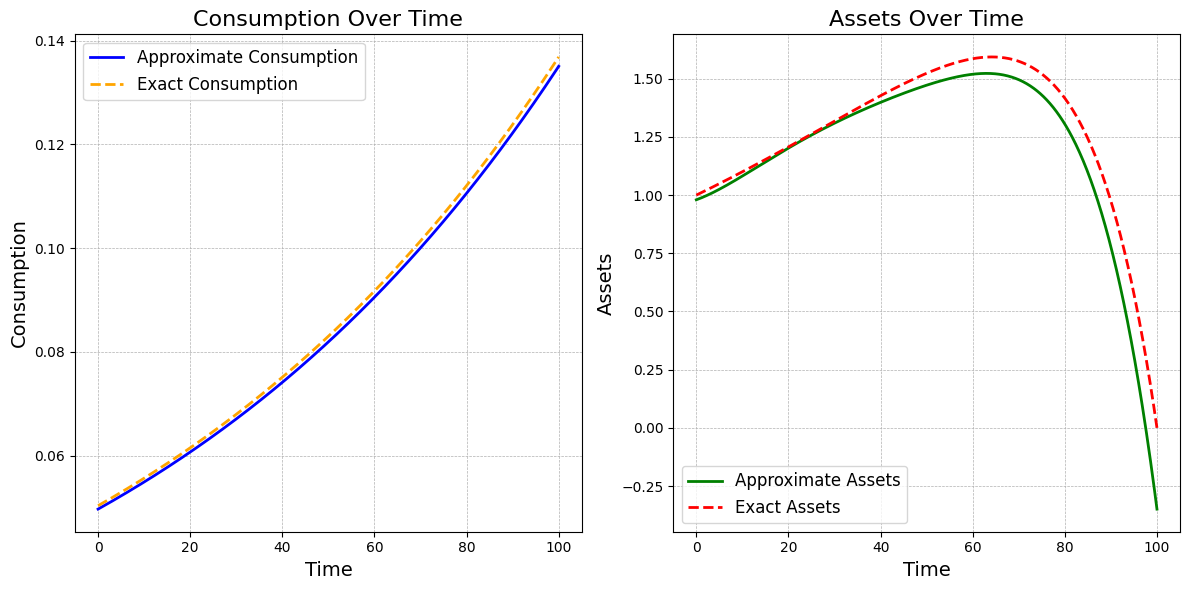

In [6]:
# We can compute the solution for this analytically and compare this with the numerically solution
def compute_exact_solution(rho, r_interest, asset_initial, asset_terminal, time_values):
    """
    This function returns:
    - asset_values (np.ndarray): Exact asset values over time
    - consumption_values (np.ndarray): Exact consumption values over time
    """
    # Initial consumption calculation based on boundary conditions
    time = time_values[-1]
    c0 = (rho * (asset_terminal * np.exp(-r_interest * time) - asset_initial)) / (np.exp(-rho * time) - 1)
    
    # Creating empty np.ndarray's for both asset and consumption
    asset_values = np.zeros(len(time_values))
    consumption_values = np.zeros(len(time_values))
    for idx, time in enumerate(time_values):
        consumption_values[idx] = c0 * np.exp((r_interest - rho) * time)
        asset_values[idx] = np.exp(r_interest * time) * (c0 * np.exp(-rho * time) / rho + asset_initial - c0 / rho)
    return asset_values, consumption_values


# =========================================================
# Chebyshev Nodes
# =========================================================
def chebyshev_nodes(a, b, n):
    """
    This function generate Chebyshev Nodes in the interval [a, b] and the function returns:
    - nodes (np.ndarray): Array of Chebyshev Nodes
    """
    k = np.arange(1, n + 1)
    nodes =  0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * k - 1) * np.pi / (2 * n))
    return nodes[:: -1]   # Reversing the order to make the nodes have a ascending order


# =========================================================
# Approximate asset value using polynomial coefficients
# =========================================================
def approximate_a(t, coeffs_a):
    """
    This function returns:
    - a_t (float): Approximated asset value at time t
    """
    n = len(coeffs_a)
    a_t = sum([coeffs_a[k] * t**k for k in range(n)])
    return a_t 


# =========================================================
# Approximate consumption value using polynomial coefficients
# =========================================================
def approximate_c(t, coeffs_c):
    """ 
    This function returns:
    - c_t (float): Approximated consumption value at time t
    """
    n = len(coeffs_c)
    c_t = sum([coeffs_c[k] * t**k for k in range(n)])
    return c_t


# =========================================================
# System Matrices for the projection method
# =========================================================
def create_system_matrices(time_nodes, n, rho, r_interest, asset_initial, asset_terminal):
    """
    This function returns:
    - A_matrix (np.ndarray): Coefficient matrix for the system
    - B_vector (np.ndarray): Right-hand side vector
    """
    num_coeffs = n + 1

    # Construct Vandermonde matrices for a(t) and c(t)
    T_matrix = np.vander(time_nodes, N=num_coeffs, increasing=True)  # For a(t)
    T_derivative_matrix = np.zeros_like(T_matrix)  # For derivative of a(t)
    for j in range(num_coeffs):
        if j == 0:
            T_derivative_matrix[:, j] = 0
        else:
            T_derivative_matrix[:, j] = j * time_nodes**(j - 1)

    # Similarly for c(t)
    C_matrix = T_matrix.copy()
    C_derivative_matrix = T_derivative_matrix.copy()

    # Construct the system matrices
    # Equation from the differential equation for a(t): a'(t) = r a(t) - c(t)
    A_diff_eq = np.hstack((T_derivative_matrix - r_interest * T_matrix, C_matrix))

    # Equation from the differential equation for c(t): c'(t) = (r - rho) c(t)
    C_diff_eq = np.hstack((np.zeros_like(T_matrix), C_derivative_matrix - (r_interest - rho) * C_matrix))

    # Boundary conditions
    # At t = 0: a(0) = a0
    a0_condition = np.hstack((T_matrix[0, :], np.zeros(num_coeffs)))
    B_a0 = asset_initial

    # At t = T: a(T) = aT
    aT_condition = np.hstack((T_matrix[-1, :], np.zeros(num_coeffs)))
    B_aT = asset_terminal

    # Combine all equations
    A_matrix = np.vstack((A_diff_eq, C_diff_eq, a0_condition, aT_condition))
    B_vector = np.zeros(A_matrix.shape[0])
    B_vector[-2] = B_a0  # From a(0) = a0
    B_vector[-1] = B_aT  # From a(T) = aT

    return A_matrix, B_vector


# =========================================================
# Projection method
# =========================================================
def compute_projection_method(rho, r_interest, asset_initial, asset_terminal, n, T):
    """
    This function returns:
    - time_values (np.ndarray): Array of time points for plotting
    - asset_approx (np.ndarray): Approximated asset values over time
    - consumption_approx (np.ndarray): Approximated consumption values over time
    """

    # Generate Chebyshev nodes
    time_nodes = chebyshev_nodes(0, T, n)

    # Create system matrices
    A_matrix, B_vector = create_system_matrices(time_nodes, n, rho, r_interest, asset_initial, asset_terminal)

    # Solve for the system of coefficients
    coeffs, residuals, rank, s = np.linalg.lstsq(A_matrix, B_vector, rcond=None)

    # Extract the coefficients for a(t) and c(t)
    coeffs_a = coeffs[: n+1]
    coeffs_c = coeffs[n + 1:]

    # Generate time values for plotting
    time_values = np.linspace(0, T, 1000)

    # Compute approximate a(t) and c(t)
    asset_approx = np.array([approximate_a(t, coeffs_a) for t in time_values])
    consumption_approx = np.array([approximate_c(t, coeffs_c) for t in time_values])

    return time_values, asset_approx, consumption_approx


# =========================================================
# Plotting the result
# =========================================================
def plot_results(time_vector, asset_exact, asset_approx, consumption_exact, consumption_approx):
    # Initializing figure size
    plt.figure(figsize=(12, 6))

    # Plot Consumption Paths
    plt.subplot(1, 2, 1)
    plt.plot(time_vector, consumption_approx, label='Approximate Consumption', linewidth=2, color='blue')
    plt.plot(time_vector, consumption_exact, '--', label='Exact Consumption', linewidth=2, color='orange')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Consumption', fontsize=14)
    plt.title('Consumption Over Time', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)

    # Plot Asset Paths
    plt.subplot(1, 2, 2)
    plt.plot(time_vector, asset_approx, label='Approximate Assets', linewidth=2, color='green')
    plt.plot(time_vector, asset_exact, '--', label='Exact Assets', linewidth=2, color='red')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Assets', fontsize=14)
    plt.title('Assets Over Time', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()


# =========================================================
# Parameters and functions for the main function
# =========================================================
def main():
    # Parameters
    rho = 0.05
    r_interest = 0.06
    T = 100
    asset_initial = 1
    asset_terminal = 0
    n = 5
    
    # Compute approximate solutions using the Projection method
    time_values, asset_approx, consumption_approx = compute_projection_method(rho, r_interest, asset_initial, asset_terminal, n, T)

    # Compute exact solution
    asset_exact, consumption_exact = compute_exact_solution(rho, r_interest, asset_initial, asset_terminal, time_values)

    # Plot the results
    plot_results(time_values, asset_exact, asset_approx, consumption_exact, consumption_approx)


# Initializing our main function
if __name__ == "__main__":
    main()

# 2. Derivatives Pricing

### 2.1 A: Crude Monte Carlo Method

In [7]:
# Own function for computing the Asian Option price with the use of Crude Monte Carlo
def asian_option_crude_monte_carlo(S0, K, r, sigma, T, M, N, seed = None):
    """
    This function returns:
    - option_price (float): Estimated price of the Asian Call option
    - variance (float): Variance of the discounted payoffs
    - conf_interval (tuple): 95% CI for the option price
    """
    # For reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Time step
    delta_t = T / M

    # Generate random variables for stock price simulation
    Z = np.random.randn(N, M)

    # Initialize stock price array
    S = np.zeros((N, M+1))
    S[:, 0] = S0

    # Simulate stock prices at each monitoring date
    for j in range(1, M + 1):
        # Update stock price based on GBM formula
        S[:, j] = S[:, j-1] * np.exp((r - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * Z[:, j-1])

    # Exclude S0 for the arithemtic average
    S_monitor = S[:, 1:]

    # Compute the arithmetic mean
    A = np.mean(S_monitor, axis = 1)

    # Compute payoffs
    payoffs = np.maximum(A - K, 0)

    # Discount the future payoffs
    discounted_payoffs = np.exp(- r * T) * payoffs

    # Estimate option price
    option_price = np.mean(discounted_payoffs)

    # Compute variance of discounted payoffs
    variance = np.var(discounted_payoffs, ddof = 1)

    # Compute the standard error
    std_error = np.sqrt(variance / N)

    # Compute the confidence interval
    conf_interval = (option_price - 1.96*std_error, option_price + 1.96*std_error)
    
    return option_price, variance, conf_interval

# =========================================================
# Parameters and functions for the main function
# =========================================================
def main():
    # Option parameters
    S0 = 50
    K = S0
    r = 0.02
    sigma = 0.2
    T = 5 / 12
    M = 5
    N = 10000  
    seed = 42

    # Price and CI of the Asian option
    price, var, conf_int = asian_option_crude_monte_carlo(S0, K, r, sigma, T, M, N, seed)

    # Display the results
    print(f"Asian Call Option Price: {price:.4f}")
    print(f"Variance of Discounted Payoffs: {var:.6f}")
    print(f"95% Confidence Interval: ({conf_int[0]:.4f}, {conf_int[1]:.4f})")


# Initializing our main function
if __name__ == "__main__":
    main()

Asian Call Option Price: 1.8588
Variance of Discounted Payoffs: 7.561902
95% Confidence Interval: (1.8049, 1.9127)


### B: Redo A but with Antithetic sampling

In [8]:
# Own function for computing the Asian Option price with the use Antithetic Sampling
def asian_option_antithetic_sample(S0, K, r, sigma, T, M, N, seed = None):
    """
    This function returns:
    - option_price (float): Estimated price of the Asian Call option
    - variance (float): Variance of the discounted payoffs
    - conf_interval (tuple): 95% CI for the option price
    """
    # For reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Number of independent simulations
    M_sim = N // 2

    # Time step
    delta_t = T / M

    # Generate random variables
    Z = np.random.randn(M_sim, M)

    # Antithetic counterpart
    Z_antithetic = -Z
    Z_combined = np.vstack((Z, Z_antithetic))

    # Initialize stock price array
    S = np.zeros((N, M+1))
    S[:, 0] = S0

    # Simulate stock prices at each monitoring date
    for j in range(1, M + 1):
        # Update stock price based on GBM formula
        S[:, j] = S[:, j-1] * np.exp((r - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * Z_combined[:, j-1])

    # Exclude S0 for the arithemtic average
    S_monitor = S[:, 1:]

    # Compute the arithmetic mean
    A = np.mean(S_monitor, axis = 1)

    # Compute payoffs
    payoffs = np.maximum(A - K, 0)

    # Discount the future payoffs
    discounted_payoffs = np.exp(- r * T) * payoffs
    
    # Average the payoffs of antithetic pairs
    avg_discounted_payoffs = (discounted_payoffs[:M_sim] + discounted_payoffs[M_sim:]) / 2

    # Estimate option price
    option_price = np.mean(avg_discounted_payoffs)

    # Compute variance of discounted payoffs
    variance = np.var(avg_discounted_payoffs, ddof = 1)

    # Compute the standard error
    std_error = np.sqrt(variance / N)

    # Compute the confidence interval
    conf_interval = (option_price - 1.96*std_error, option_price + 1.96*std_error)
    
    return option_price, variance, conf_interval

# =========================================================
# Parameters and functions for the main function
# =========================================================
def main():
    # Option parameters
    S0 = 50
    K = S0
    r = 0.02
    sigma = 0.2
    T = 5 / 12
    M = 5
    N = 10000
    seed = 42

    # Price and CI of the Asian option
    price, var, conf_int = asian_option_antithetic_sample(S0, K, r, sigma, T, M, N, seed)

    # Display the results
    print(f"Asian Call Option Price: {price:.4f}")
    print(f"Variance of Discounted Payoffs: {var:.6f}")
    print(f"95% Confidence Interval: ({conf_int[0]:.4f}, {conf_int[1]:.4f})")


# Initializing our main function
if __name__ == "__main__":
    main()

Asian Call Option Price: 1.8427
Variance of Discounted Payoffs: 2.010573
95% Confidence Interval: (1.8149, 1.8705)


### C: Redo A but with Control Variates

In [9]:
# Own function for computing the Asian Option price with Control Variates
def asian_option_control_variates(S0, K, r, sigma, T, M, N, seed = None):
    """
    This function returns:
    - option_price (float): Estimated price of the Asian Call option
    - variance (float): Variance of the discounted payoffs
    - conf_interval (tuple): 95% CI for the option price
    """
    # For reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Time step
    delta_t = T / M

    # Generate random variables for stock price simulation
    Z = np.random.randn(N, M)

    # Initialize stock price array
    S = np.zeros((N, M+1))
    S[:, 0] = S0

    # Simulate stock prices at each monitoring date
    for j in range(1, M + 1):
        # Update stock price based on GBM formula
        S[:, j] = S[:, j-1] * np.exp((r - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * Z[:, j-1])

    # Exclude S0 for the arithemtic average
    S_monitor = S[:, 1:]

    # Compute the arithmetic mean
    A = np.mean(S_monitor, axis = 1)

    # Compute payoffs
    payoffs = np.maximum(A - K, 0)

    # Compute Control Variate
    t_j = np.arange(1, M + 1) * delta_t
    E_A = (S0 / M) * np.sum(np.exp(r * t_j))

    # Compute covariance between payoffs and A
    cov_matrix = np.cov(payoffs, A, ddof = 1)
    cov_payoff_A = cov_matrix[0, 1]

    # Compute variance of A
    var_A = cov_matrix[1, 1]

    # Optimal coefficient c
    c = cov_payoff_A / var_A

    # Adjust payoffs using Control Variates
    adjusted_payoffs = payoffs - c *(A - E_A) 

    # Discount the future payoffs
    discounted_payoffs_adjusted = np.exp(- r * T) * adjusted_payoffs

    # Estimate option price
    option_price = np.mean(discounted_payoffs_adjusted)

    # Compute variance of discounted payoffs
    variance = np.var(discounted_payoffs_adjusted, ddof = 1)

    # Compute the standard error
    std_error = np.sqrt(variance / N)

    # Compute the confidence interval
    conf_interval = (option_price - 1.96*std_error, option_price + 1.96*std_error)
    
    return option_price, variance, conf_interval

# =========================================================
# Parameters and functions for the main function
# =========================================================
def main():
    # Option parameters
    S0 = 50
    K = S0
    r = 0.02
    sigma = 0.2
    T = 5 / 12
    M = 5
    N = 10000
    seed = 42

    # Price and CI of the Asian option
    price, var, conf_int = asian_option_control_variates(S0, K, r, sigma, T, M, N, seed)

    # Display the results
    print(f"Asian Call Option Price: {price:.4f}")
    print(f"Variance of Discounted Payoffs: {var:.6f}")
    print(f"95% Confidence Interval: ({conf_int[0]:.4f}, {conf_int[1]:.4f})")


# Initializing our main function
if __name__ == "__main__":
    main()

Asian Call Option Price: 1.8519
Variance of Discounted Payoffs: 1.650994
95% Confidence Interval: (1.8267, 1.8770)


### D: Redo A but with Quasi-Monte Carlo, and use Halton Sequence

In [10]:
# Own function for computing the Asian Option price with the use of Quasi-Monte Carlo and Halton Sequence
def asian_option_call_qmc(S0, K, r, sigma, T, N, M, seed=None, sequence_type = "halton"):
    """
    This function returns:
    - option_price (float): Estimated price of the Asian Call option
    """
    # Initialize Halton sampler (setting Scramle=False, we maintain pure deterministic)
    sampler = qmc.Halton(d = M, scramble=False, seed=seed)

    # Generate N quasi-random samples
    samples = sampler.random(N)

    # Transform uniform samples to standard normal using inverse CDF
    Z = norm.ppf(samples)

    # Initialize stock price array
    S = np.zeros((N, M+1))
    S[:, 0] = S0

    # Time step
    delta_t = T / M

    # Simulate stock prices at each monitoring date
    for j in range(1, M + 1):
        # Update stock price based on GBM formula
        S[:, j] = S[:, j-1] * np.exp((r - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * Z[:, j-1])

    # Exclude S0 for the arithemtic average
    S_monitor = S[:, 1:]

    # Compute the arithmetic mean
    A = np.mean(S_monitor, axis = 1)

    # Compute payoffs
    payoffs = np.maximum(A - K, 0)

    # Discount the future payoffs
    discounted_payoffs = np.exp(- r * T) * payoffs

    # Estimate option price
    option_price = np.mean(discounted_payoffs)
    
    return option_price

# =========================================================
# Parameters and functions for the main function
# =========================================================
def main():
    # Option parameters
    S0 = 50
    K = S0
    r = 0.02
    sigma = 0.2
    T = 5 / 12
    M = 5
    N = 10000
    seed = 42

    # Price and CI of the Asian option
    price = asian_option_call_qmc(S0, K, r, sigma, T, N, M, seed)

    # Display the results
    print(f"Asian Call Option Price: {price:.4f}")


# Initializing our main function
if __name__ == "__main__":
    main()

Asian Call Option Price: 1.8178


## 2.2: Call on Call Compounded Option

In [11]:
# =========================================================
# Price an American Call Option Using LSM
# =========================================================
def american_call_lsm_quadratic_at_t(S_t, K, r, q, sigma, T_remaining, n_timesteps_remaining, dW = None):
    """
    This function returns:
    - option_price (float): Estimated price of the American call option at time t
    """
    N = len(S_t)
    dt = T_remaining / n_timesteps_remaining
    discount = np.exp(-r * dt)

    if dW is None:
        dW = np.sqrt(dt) * np.random.randn(N, n_timesteps_remaining)

    # Initialize stock price paths
    S = np.zeros((N, n_timesteps_remaining + 1))
    S[:, 0] = S_t
    for t in range(1, n_timesteps_remaining + 1):
        S[:, t] = S[:, t-1] * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * dW[:, t-1])

    # Initialize option values with payoff at maturity
    h = np.maximum(S[:, -1] - K, 0)
    V = h.copy()
    # Backward induction for option pricing
    for t in range(n_timesteps_remaining - 1, 0, -1):
        # Identify in-the-money paths
        itm = np.where(S[:, t] > K)[0]
        if len(itm) > 0:
            # Prepare regression variables (quadratic basis)
            X = np.vstack((S[itm, t], S[itm, t]**2)).T
            Y = V[itm] * discount
            
            # Fit linear regression model
            model = LinearRegression().fit(X, Y)
            
            # Predict continuation values for in-the-money paths
            continuation_val = model.predict(X)
            
            # Immediate exercise value
            immediate_exercise = S[itm, t] - K
            
            # Decide to exercise or continue
            exercise = immediate_exercise > continuation_val
            
            # Update option values based on exercise decision
            V[itm] = np.where(exercise, immediate_exercise, V[itm] * discount)
        else:
            # Discount option values if no paths are in-the-money
            V = V * discount
    
    # Estimate option price as the average of discounted payoffs
    option_price = np.mean(V) * discount
    return option_price


# =========================================================
# Pricing Asian Call on American Calls
# =========================================================
def asian_option_on_american_calls(S0, Ka, Kc, r, q, sigma, T, n_timesteps, n_paths, seed=None):
    """  
    This function returns:
    - Ca_price (float): Estimated price of the compound option Ca. 
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Time step size
    dt = T / n_timesteps
    monitoring_dates = np.linspace(dt, T, num=5)

    # 1: Simulate stock price paths
    dW = np.sqrt(dt) * np.random.randn(n_paths, n_timesteps)
    S = np.zeros((n_paths, n_timesteps + 1))
    S[:, 0] = S0
    for t in range (1, n_timesteps + 1):
        # Simulate according to GBM
        S[:, t] = S[:, t-1] * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * dW[:, t-1])

    # 2: Price Cc at each monitoring date using LSM
    Cc_values = np.zeros((n_paths, len(monitoring_dates)))
    for i, md in enumerate(monitoring_dates):
        t_index = int(np.round(md / dt))
        # Ensure t_index does not exceed the number of timesteps
        t_index = min(t_index, n_timesteps)
        
        if t_index == n_timesteps:
            # At maturity, Cc payoff is max(S_T - Kc, 0)
            Cc_values[:, i] = np.maximum(S[:, t_index] - Kc, 0)
        else:
            # Remaining time for Cc
            T_remaining = T - md
            n_timesteps_remaining = n_timesteps - t_index
            S_t = S[:, t_index]
            Cc_prices = american_call_lsm_quadratic_at_t(S_t, Kc, r, q, sigma, T_remaining, n_timesteps_remaining)
            Cc_values[:, i] = Cc_prices
     
    # 3: Compute the arithmetic average of Cc prices for each path
    average_Cc = np.mean(Cc_values, axis=1)
    
    # 4: Compute the payoff of Ca for each path
    payoff = np.maximum(average_Cc - Ka, 0)
    
    # 5: Discount the payoff to present value
    discounted_payoff = payoff * np.exp(-r * T)
    
    # 6: Estimate Ca's price by averaging the discounted payoffs
    Ca_price = np.mean(discounted_payoff)
    
    return Ca_price


# =========================================================
# Calculating Delta and Gamma using FDM
# =========================================================
def calculate_delta_gamma(S0, Ka, Kc, r, q, sigma, T, n_timesteps, n_paths, delta_S, seed=None):
    """
    This function returns:
    - Delta (float): Estimated delta of the compound option
    - Gamma (float): Estimated gamma of the compound option
    """
    # Price for S0
    V_S0 = asian_option_on_american_calls(S0, Ka, Kc, r, q, sigma, T, n_timesteps, n_paths, seed)
    
    # Price for S0 + delta_S
    V_S0_plus = asian_option_on_american_calls(S0 + delta_S, Ka, Kc, r, q, sigma, T, n_timesteps, n_paths, seed)

    # Price for S0 - delta_S
    V_S0_minus = asian_option_on_american_calls(S0 - delta_S, Ka, Kc, r, q, sigma, T, n_timesteps, n_paths, seed)

    # FDM 
    delta = (V_S0_plus - V_S0_minus) / (2 * delta_S)
    gamma = (V_S0_plus - (2 *V_S0) + V_S0_minus) / (delta_S ** 2)

    return delta, gamma



# =========================================================
# Parameters and functions for the main function
# =========================================================
def main():
    S0 = 50
    Kc = S0
    Ka = 3
    r = 0.03
    q = 0.01
    sigma = 0.4
    T = 5 / 12
    n_timesteps = 100
    n_paths = 10000
    delta_S = 1.5
    seed = 42

    # Compound option Ca
    Ca_price = asian_option_on_american_calls(S0, Ka, Kc, r, q, sigma, T, n_timesteps, n_paths, seed)
    print(f"The estimated price of the arithmetic Asian option Ca is: ${Ca_price:.4f}")

    # Calculate Delta and Gamma
    delta, gamma = calculate_delta_gamma(S0, Ka, Kc, r, q, sigma, T, n_timesteps, n_paths, delta_S, seed)
    print(f"Delta (Δ) of Ca: {delta:.4f}")
    print(f"Gamma (Γ) of Ca: {gamma:.4f}")


# Initializing our main function
if __name__ == "__main__":
    main()

The estimated price of the arithmetic Asian option Ca is: $2.2646
Delta (Δ) of Ca: 0.5543
Gamma (Γ) of Ca: 0.0373
